In [1]:
# install pytorch (http://pytorch.org/) if run from Google Colaboratory
import sys

%matplotlib inline
import os

import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
import os
from PIL import Image, ImageOps

def crop_image(img, zoom_factor=0.9):
    """
    Crop the edges of the image to zoom in.

    :param img: PIL Image object
    :param zoom_factor: Fraction of the image to retain (0.9 = crop 10% off each side)
    :return: Cropped PIL Image object
    """
    width, height = img.size
    new_width = int(width * zoom_factor)
    new_height = int(height * zoom_factor)

    # Calculate the coordinates to crop the center of the image
    left = (width - new_width) // 2
    top = (height - new_height) // 2
    right = (width + new_width) // 2
    bottom = (height + new_height) // 2

    return img.crop((left, top, right, bottom))

# Root directory containing images
input_folder = 'Processed_Images'  # Update this to the folder containing your images
output_folder = 'Inverted_Cropped_Images'  # Folder to save the inverted and cropped images

# Create output folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

# Walk through all subdirectories and files in the input folder
for subdir, _, files in os.walk(input_folder):
    for file in files:
        if file.endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):  # Process image files only
            file_path = os.path.join(subdir, file)

            try:
                # Load the image
                img = Image.open(file_path).convert("L")  # Convert to grayscale ("L" mode)

                # Invert the colors first
                inverted_img = ImageOps.invert(img)

                # Zoom in by cropping the edges of the inverted image
                cropped_img = crop_image(inverted_img, zoom_factor=0.9)

                # Create output directory structure
                relative_path = os.path.relpath(subdir, input_folder)
                output_subdir = os.path.join(output_folder, relative_path)
                os.makedirs(output_subdir, exist_ok=True)

                # Save the inverted and cropped image
                output_path = os.path.join(output_subdir, f"inverted_cropped_{file}")
                cropped_img.save(output_path)


            except Exception as e:
                pass

print("All images processed and saved.")


In [3]:
# 2-d latent space, parameter count in same order of magnitude
# as in the original VAE paper (VAE paper has about 3x as many)
latent_dims = 15
num_epochs = 400
batch_size = 64
capacity = 64*2
learning_rate = 1e-3
variational_beta = 0.1
use_gpu = True

# # 10-d latent space, for comparison with non-variational auto-encoder
# latent_dims = 10
# num_epochs = 100
# batch_size = 128
# capacity = 64
# learning_rate = 1e-3
# variational_beta = 1
# use_gpu = True

In [4]:
import os
from PIL import Image
import torchvision.transforms as transforms

# augment_transform = transforms.Compose([
#     transforms.RandomRotation(degrees=15),   # Rotate image randomly within +/- 15 degrees
#     transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),  # Adjust color
#     transforms.RandomResizedCrop(size=(128, 128), scale=(0.8, 1.0)),  # Randomly resize and crop
# ])

augment_transform = transforms.Compose([
    transforms.RandomRotation(degrees=(-50, -25)),   # Random rotation between 5 and 25 degrees
    transforms.ColorJitter(brightness=0.6, contrast=0.4, saturation=0.4, hue=0.2),  # Increase randomness in color adjustments
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Add random translation to shift the image slightly
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),  # Apply Gaussian blur with random strength
])


# Path to your folder (e.g., 'Processed_Images')
root_dir = 'Inverted_Cropped_Images'  # Update this to your correct path
output_dir = 'Inverted_Cropped_Images'  # Directory to save augmented images

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Number of augmentations per image
augmentations_per_image = 1  # To generate over 1000 images, 250 augmentations per image (4 images * 250)

#augmentations_per_image = 5  # To generate over 5000


# Loop through each folder (e.g., '1', '2', ...)
for folder_name in os.listdir(root_dir):
    folder_path = os.path.join(root_dir, folder_name)
    if os.path.isdir(folder_path):
        # Create a corresponding output folder
        output_folder_path = os.path.join(output_dir, folder_name)
        os.makedirs(output_folder_path, exist_ok=True)
        
        # Loop through each image in the folder
        for image_name in os.listdir(folder_path):
            image_path = os.path.join(folder_path, image_name)
            
            try:
                # Open the image
                img = Image.open(image_path)

                # Apply augmentation multiple times
                for i in range(augmentations_per_image):
                    # Apply augmentation
                    augmented_img = augment_transform(img)

                    # Save augmented image with a new name
                    augmented_image_name = f"augmented_{i}_{image_name}"
                    augmented_image_path = os.path.join(output_folder_path, augmented_image_name)
                    augmented_img.save(augmented_image_path)
                            
            except Exception as e:
                print(f"Failed to process {image_path}: {e}")

print("Augmentation completed!")


In [5]:
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader

# Define transformations (if necessary)
img_transform = transforms.Compose([
    transforms.Resize((28, 28)),  # Resize the images to 128x128 (or any size you prefer)
    transforms.Grayscale(num_output_channels=1),  # Convert 3-channel RGB to 1-channel grayscale
    transforms.ToTensor()  # Convert images to tensors
])

# Load the dataset using ImageFolder
# root directory should point to 'mnist_images' where the digit folders are located
mnist_images_dataset = ImageFolder(root='/kaggle/input/inverted-cropped-images', transform=img_transform)
train_dataloader = DataLoader(mnist_images_dataset, batch_size=batch_size, shuffle=True)



test_dataloader = DataLoader(mnist_images_dataset, batch_size=batch_size, shuffle=True)

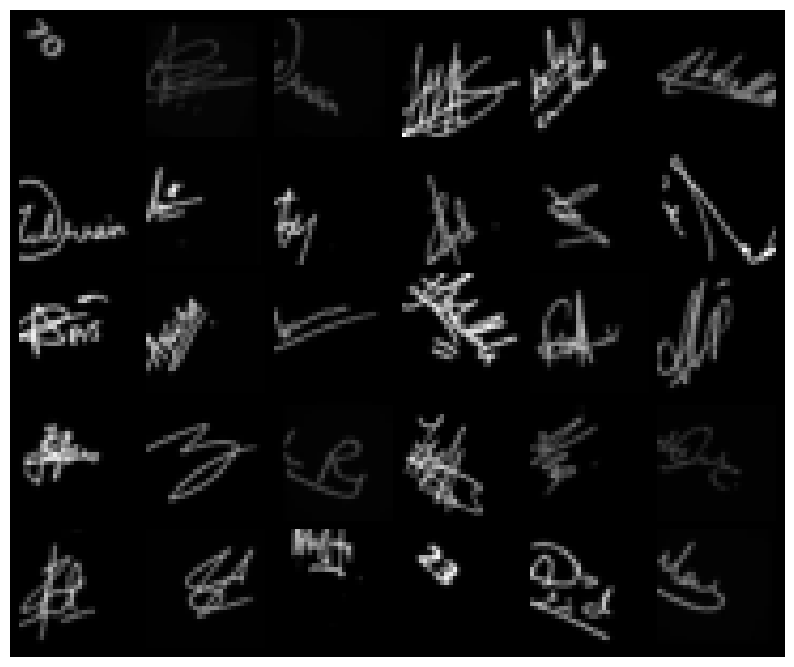

In [6]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils

# Get a batch of images from the train dataloader
data_iter = iter(train_dataloader)
images, labels = next(data_iter)  # Get the next batch of images

# Select how many images you want to show (up to 30)
num_images_to_show = 30
images_to_show = images[:num_images_to_show]

# Create a grid of images
grid_img = vutils.make_grid(images_to_show, nrow=6, padding=2, normalize=True)  # nrow=6 means 6 images per row

# Plot the grid
plt.figure(figsize=(10, 10))
plt.imshow(grid_img.permute(1, 2, 0))  # Permute the dimensions to show the image correctly
plt.axis('off')  # Turn off the axis
plt.show()


In [7]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        c = capacity
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=c, kernel_size=4, stride=2, padding=1) # out: c x 14 x 14
        self.conv2 = nn.Conv2d(in_channels=c, out_channels=c*2, kernel_size=4, stride=2, padding=1) # out: c x 7 x 7
        self.fc_mu = nn.Linear(in_features=c*2*7*7, out_features=latent_dims)
        self.fc_logvar = nn.Linear(in_features=c*2*7*7, out_features=latent_dims)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1) # flatten batch of multi-channel feature maps to a batch of feature vectors
        x_mu = self.fc_mu(x)
        x_logvar = self.fc_logvar(x)
        return x_mu, x_logvar

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        c = capacity
        self.fc = nn.Linear(in_features=latent_dims, out_features=c*2*7*7)
        self.conv2 = nn.ConvTranspose2d(in_channels=c*2, out_channels=c, kernel_size=4, stride=2, padding=1)
        self.conv1 = nn.ConvTranspose2d(in_channels=c, out_channels=1, kernel_size=4, stride=2, padding=1)

    def forward(self, x):
        x = self.fc(x)
        x = x.view(x.size(0), capacity*2, 7, 7) # unflatten batch of feature vectors to a batch of multi-channel feature maps
        x = F.relu(self.conv2(x))
        x = torch.sigmoid(self.conv1(x)) # last layer before output is sigmoid, since we are using BCE as reconstruction loss
        return x

class VariationalAutoencoder(nn.Module):
    def __init__(self):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        latent_mu, latent_logvar = self.encoder(x)
        latent = self.latent_sample(latent_mu, latent_logvar)
        x_recon = self.decoder(latent)
        return x_recon, latent_mu, latent_logvar

    def latent_sample(self, mu, logvar):
        if self.training:
            # the reparameterization trick
            std = logvar.mul(0.5).exp_()
            eps = torch.empty_like(std).normal_()
            return eps.mul(std).add_(mu)
        else:
            return mu

def vae_loss(recon_x, x, mu, logvar):
    # recon_x is the probability of a multivariate Bernoulli distribution p.
    # -log(p(x)) is then the pixel-wise binary cross-entropy.
    # Averaging or not averaging the binary cross-entropy over all pixels here
    # is a subtle detail with big effect on training, since it changes the weight
    # we need to pick for the other loss term by several orders of magnitude.
    # Not averaging is the direct implementation of the negative log likelihood,
    # but averaging makes the weight of the other loss term independent of the image resolution.
    recon_loss = F.binary_cross_entropy(recon_x.view(-1, 28*28), x.view(-1, 784), reduction='sum')

    # KL-divergence between the prior distribution over latent vectors
    # (the one we are going to sample from when generating new images)
    # and the distribution estimated by the generator for the given image.
    kldivergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return recon_loss + variational_beta * kldivergence


vae = VariationalAutoencoder()

device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
vae = vae.to(device)

num_params = sum(p.numel() for p in vae.parameters() if p.requires_grad)
print('Number of parameters: %d' % num_params)

Number of parameters: 1630239


In [8]:
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0):
        """
        Initialize the early stopping mechanism.

        :param patience: Number of epochs to wait for improvement before stopping.
        :param min_delta: Minimum change in the monitored quantity to qualify as an improvement.
        """
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = None
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0  # Reset counter if validation loss improves
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

# Initialize EarlyStopping with patience of 10 epochs
early_stopper = EarlyStopping(patience=30)

optimizer = torch.optim.Adam(params=vae.parameters(), lr=learning_rate, weight_decay=1e-5)

# set to training mode
vae.train()

train_loss_avg = []

print('Training ...')
for epoch in range(num_epochs):
    train_loss_avg.append(0)
    num_batches = 0

    for image_batch, _ in train_dataloader:

        image_batch = image_batch.to(device)

        # vae reconstruction
        image_batch_recon, latent_mu, latent_logvar = vae(image_batch)

        # reconstruction error
        loss = vae_loss(image_batch_recon, image_batch, latent_mu, latent_logvar)

        # backpropagation
        optimizer.zero_grad()
        loss.backward()

        # one step of the optimizer (using the gradients from backpropagation)
        optimizer.step()

        train_loss_avg[-1] += loss.item()
        num_batches += 1

    train_loss_avg[-1] /= num_batches
    print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, num_epochs, train_loss_avg[-1]))

    # Early stopping check (use validation loss instead of train_loss_avg[-1] if available)
    val_loss = train_loss_avg[-1]  # Replace with actual validation loss if you have a validation set
    early_stopper(val_loss)

    if early_stopper.early_stop:
        print(f"Early stopping triggered at epoch {epoch+1}")
        break


Training ...
Epoch [1 / 400] average reconstruction error: 9558.420064
Epoch [2 / 400] average reconstruction error: 8294.052073
Epoch [3 / 400] average reconstruction error: 8098.702098
Epoch [4 / 400] average reconstruction error: 8014.272845
Epoch [5 / 400] average reconstruction error: 7958.885410
Epoch [6 / 400] average reconstruction error: 7923.366609
Epoch [7 / 400] average reconstruction error: 7893.844315
Epoch [8 / 400] average reconstruction error: 7862.465763
Epoch [9 / 400] average reconstruction error: 7841.442936
Epoch [10 / 400] average reconstruction error: 7818.354077
Epoch [11 / 400] average reconstruction error: 7796.819870
Epoch [12 / 400] average reconstruction error: 7780.050164
Epoch [13 / 400] average reconstruction error: 7760.445232
Epoch [14 / 400] average reconstruction error: 7741.886321
Epoch [15 / 400] average reconstruction error: 7728.118293
Epoch [16 / 400] average reconstruction error: 7710.959211
Epoch [17 / 400] average reconstruction error: 7693.

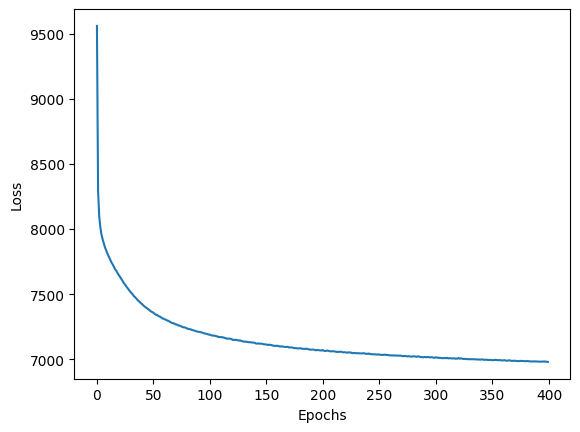

In [10]:
import matplotlib.pyplot as plt
plt.ion()

fig = plt.figure()
plt.plot(train_loss_avg)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

Original images


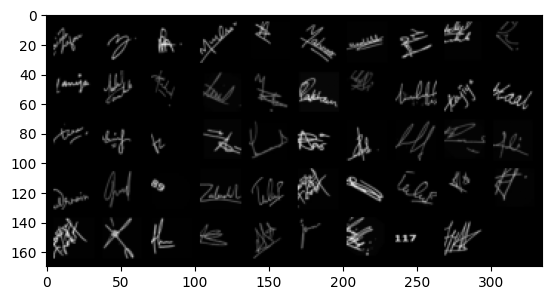

VAE reconstruction:


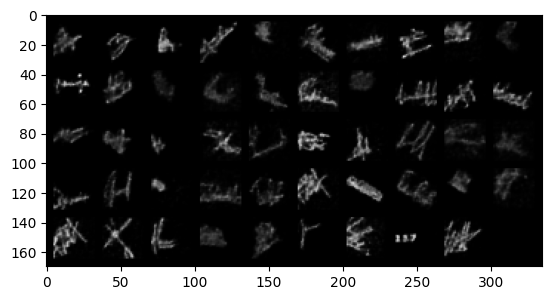

In [11]:
import numpy as np
import matplotlib.pyplot as plt
plt.ion()

import torchvision.utils

vae.eval()

# This function takes as an input the images to reconstruct
# and the name of the model with which the reconstructions
# are performed
def to_img(x):
    x = x.clamp(0, 1)
    return x

def show_image(img):
    img = to_img(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

def visualise_output(images, model):

    with torch.no_grad():

        images = images.to(device)
        images, _, _ = model(images)
        images = images.cpu()
        images = to_img(images)
        np_imagegrid = torchvision.utils.make_grid(images[1:50], 10, 5).numpy()
        plt.imshow(np.transpose(np_imagegrid, (1, 2, 0)))
        plt.show()

# Updated line to fix the error
images, labels = next(iter(test_dataloader))

# First visualise the original images
print('Original images')
show_image(torchvision.utils.make_grid(images[1:50],10,5))
plt.show()

# Reconstruct and visualise the images using the vae
print('VAE reconstruction:')
visualise_output(images, vae)


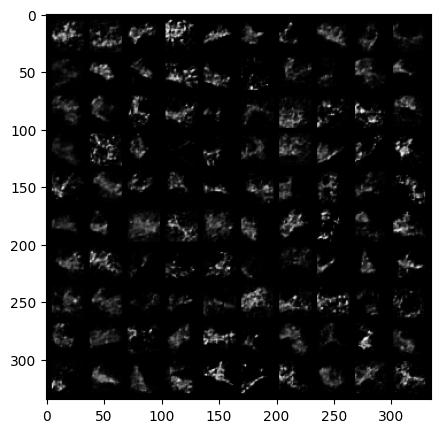

In [12]:
vae.eval()

with torch.no_grad():

    # sample latent vectors from the normal distribution
    latent = torch.randn(128, latent_dims, device=device)

    # reconstruct images from the latent vectors
    img_recon = vae.decoder(latent)
    img_recon = img_recon.cpu()

    fig, ax = plt.subplots(figsize=(5, 5))
    show_image(torchvision.utils.make_grid(img_recon.data[:100],10,5))
    plt.show()